# How to perform back projection of feature weights?

One of the potential issues of employing high dimensional parcellations is they can become difficult to interpret. While it would be great if there were existing high dimensional easy to interpret parcellations, this is not the case in practice. Instead, we propose that feature importances generated from parcellations that are not well suited to being discussed easily, (e.g., randomly generated or parcellations with thousands of regions), be back projected onto their original surface representation. Once represented at the vertex / surface level, it should be possible for researchers to interpret their findings as there exists an extensive literature of results presented and interpreted in the standard space. One could even re-parcellate results into a familiar anatomical atlas if desired.

This example covers the back projection of feature weights to native surface space for a number of different pipeline / parcellation pairs explored in the main project.

In [1]:
import sys
sys.path.append("../exp/")

from models import get_pipe
import BPt as bp
import numpy as np
import os
from neurotools.plotting import plot

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


We use the already saved dataset, but with one tweak to make out lives a little easier. Instead of using the consolidated data files, we load each seperately so that they are easier to plot and keep track of.

In [2]:
# Load in dataset
data = bp.read_pickle('../data/dataset.pkl')

# Let's replace the loaded consolidated data files
data = bp.Dataset(data['target'])
data = data.set_role(scope=list(data), role='target')
data.shape

# Add data files
files = {'curv': '../data/abcd_structural/curv/*.npy',
         'sulc': '../data/abcd_structural/sulc/*.npy',
         'thick': '../data/abcd_structural/thick/*.npy',
         'myelin': '../data/abcd_structural/myelin/*.npy'}
data = data.add_data_files(files, file_to_subject='auto')

# Drop all data w/ all missing target
data = data.drop_subjects_by_nan('target', threshold=.99)

data.get_cols('data'), data.shape

Setting NaN threshold to: 44.55
Dropped 597 Rows


(['curv', 'myelin', 'sulc', 'thick'], (9432, 49))

Next, we setup some common varaibles, as well as wrap the evaluate function in a helper function, and put the code used to plot the average inverse transformed feature weights for each modality.

In this example, we will we predicting the regression target variable - 'anthro_waist_cm'. That said, all of the above code is designed to work with binary based targets as well (if running the code yourself, you can try changing the variable).

In [3]:
# Set problem spec
ps = bp.ProblemSpec(target='anthro_waist_cm',
                    random_state=5)

# Helper function around eval
def run_eval(pipe, n_jobs=8):
    
    # Run evaluate
    return bp.evaluate(pipeline=pipe,
                       dataset=data,
                       problem_spec=ps,
                       subjects='all',
                       n_jobs=n_jobs,
                       mute_warnings=True,
                       cv=5)

def plot_avg(inverse_fis):
    
    # Get average
    avg_inverse = np.mean(np.array(inverse_fis), axis=0)
    
    # Set colorbar max and min same across each
    # m = np.max(np.abs(avg_inverse))
    # m *= 1.05
    
    # Use mean val as threshold
    thresh = np.mean(np.mean(np.abs(avg_inverse)))
    
    # Plot average features for each modality seperate
    for name, vals in zip(inverse_fis[0].index, avg_inverse):
        plot(vals, threshold=thresh, title=name)

## Base Elastic-Net

The first example we will look at is simply back projecting the weights from an elastic-net based pipeline from one of the randomly generated parcellations. Since this regressor generates beta-weights, it is relatively simple to back project this values according to the values of the parcellation.

In [4]:
# Get pipelines
pipe = get_pipe('elastic', 'random_50_0')

# Run evaluate
results = run_eval(pipe)

Get pipeline with: elastic random_50_0 None
cache_fit_loc: None
Predictions will still be made for any subjects with missing values in any validation folds.
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 4 features).
Evaluating 9432 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (7538, 4) (skipped 7 NaN targets)
Validation Set: (1882, 4) (skipped 5 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0566
neg_mean_squared_error: -19.84

Training Set: (7535, 4) (skipped 10 NaN targets)
Validation Set: (1885, 4) (skipped 2 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0811
neg_mean_squared_error: -23.41

Training Set: (7537, 4) (skipped 9 NaN targets)
Validation Set: (1883, 4) (skipped 3 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0689
neg_mean_squared_error: -22.35

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0618
neg_mean_squared_error: -20.88

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0798
neg_mean_squared_error: -17.87



The back projected feature importancescan be obtained with special BPt function `get_inverse_fis`.

In [5]:
inverse_fis = results.get_inverse_fis()

Looking a little closer, we see this returns us a list of pandas Series

In [6]:
len(inverse_fis), inverse_fis[0]

(5,
 curv      [0.018847158, -0.007000035, -0.007000035, -0.5...
 myelin    [0.0, 0.0, 0.0, -2.4028604, 3.305909, -10.3928...
 sulc      [0.9584251, -0.14789416, -0.14789416, 0.101624...
 thick     [-0.29126185, 0.4006583, 0.4006583, -0.3283814...
 dtype: object)

We can further see that the first fold, first modality has the correct shape / number of values per vertex.

In [7]:
inverse_fis[0][0].shape

(64984,)

Now, if we are interested in plotting, we can generate average values across all 5 folds to plot as such:

In [8]:
avg_inverse = np.mean(np.array(inverse_fis), axis=0)
avg_inverse.shape, avg_inverse[0].shape

((4,), (64984,))

This logic is already wrapped up in the plotting function, let's try it here.

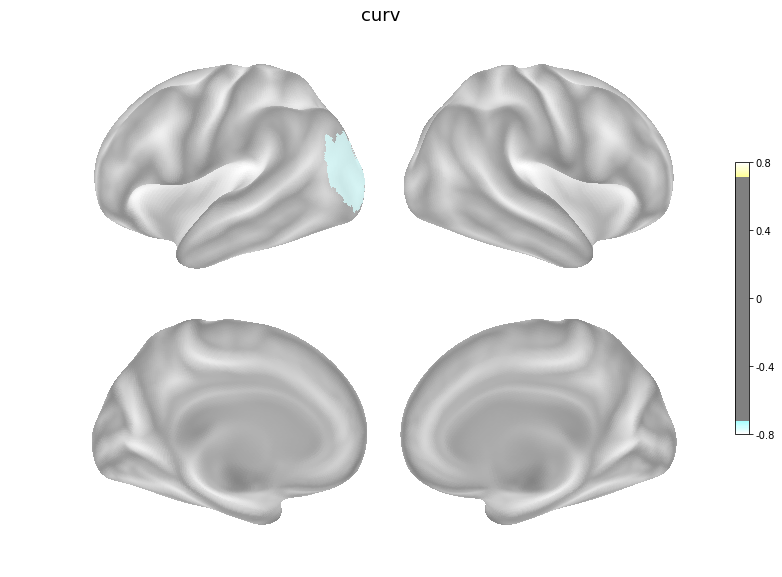

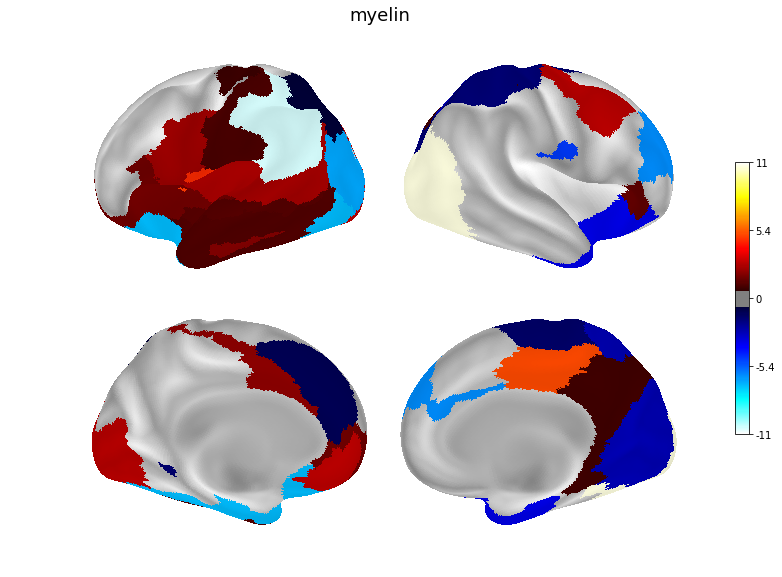

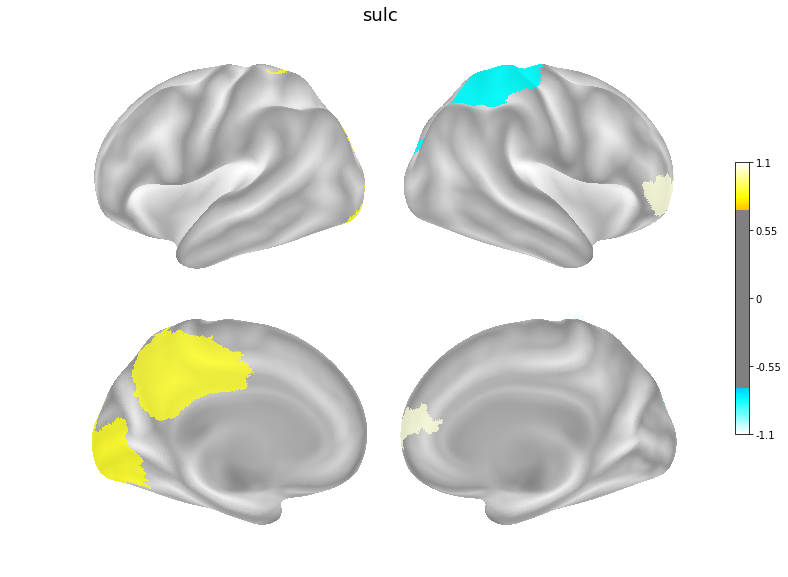

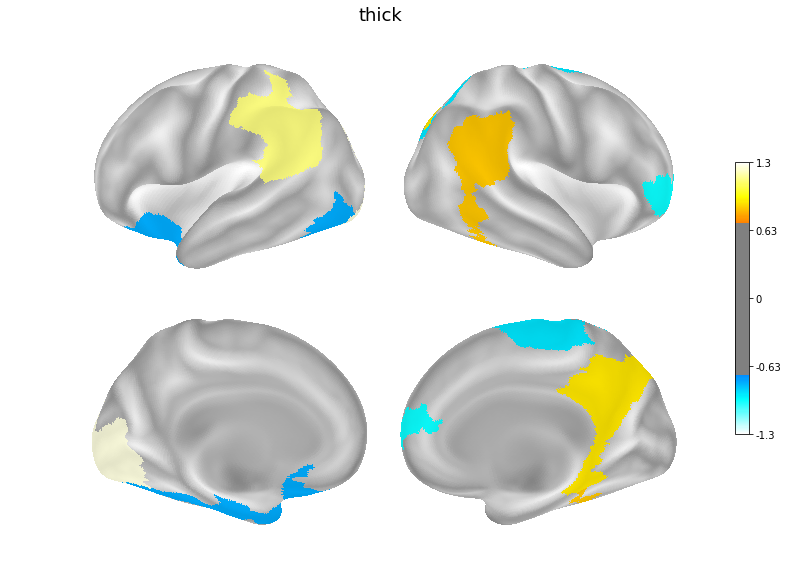

In [9]:
plot_avg(inverse_fis)

## Base - LGBM

As out next example, we are just using an LGBM based pipeline instead of the elastic-net one. In this case we just repeat the same steps, except this time we are plotting the automatically computed LGBM based metrics of feature importance, instead of beta weights.

Get pipeline with: lgbm random_50_0 None
cache_fit_loc: None
Predictions will still be made for any subjects with missing values in any validation folds.
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 4 features).
Evaluating 9432 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (7538, 4) (skipped 7 NaN targets)
Validation Set: (1882, 4) (skipped 5 NaN targets)
Fit fold in 0.7 seconds.
explained_variance: 0.0643
neg_mean_squared_error: -24.42

Training Set: (7535, 4) (skipped 10 NaN targets)
Validation Set: (1885, 4) (skipped 2 NaN targets)
Fit fold in 1.9 seconds.
explained_variance: 0.0693
neg_mean_squared_error: -26.41

Training Set: (7537, 4) (skipped 9 NaN targets)
Validation Set: (1883, 4) (skipped 3 NaN targets)
Fit fold in 1.1 seconds.
explained_variance: 0.0595
neg_mean_squared_error: -25.78

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 0.9 seconds.
explained_variance: 0.0686
neg_mean_squared_error: -31.15

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 1.1 seconds.
explained_variance: 0.0687
neg_mean_squared_error: -24.11



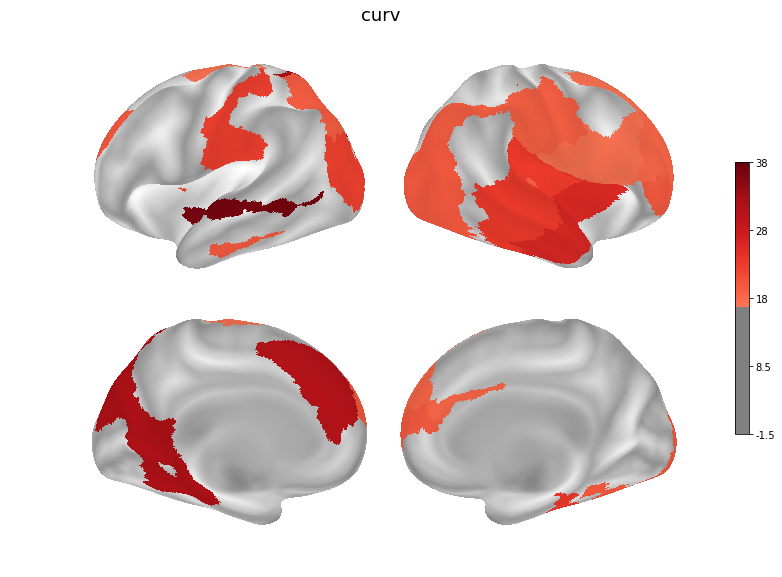

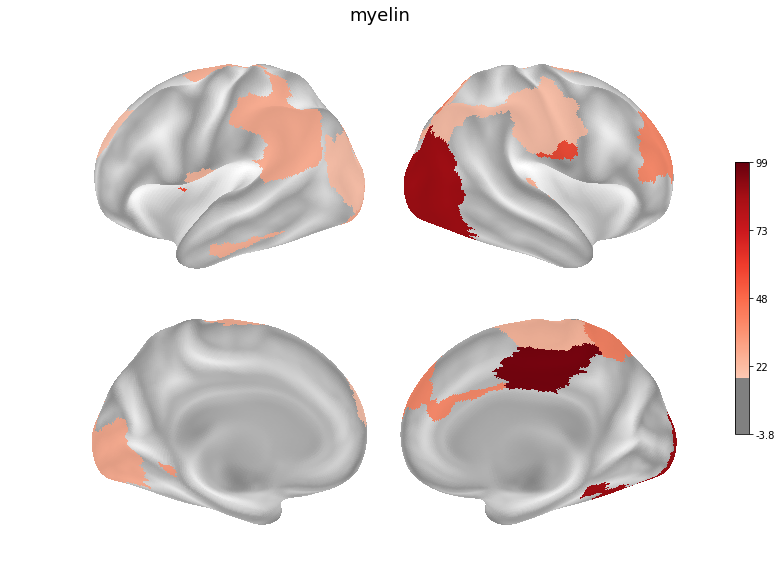

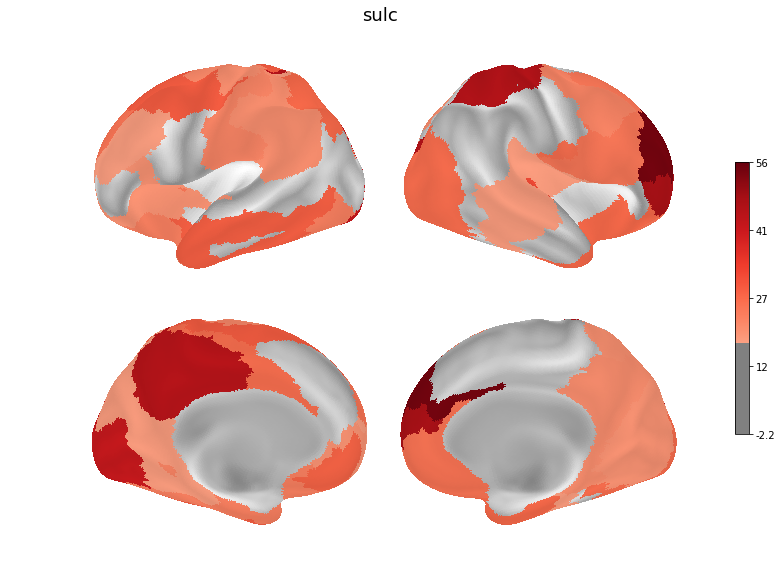

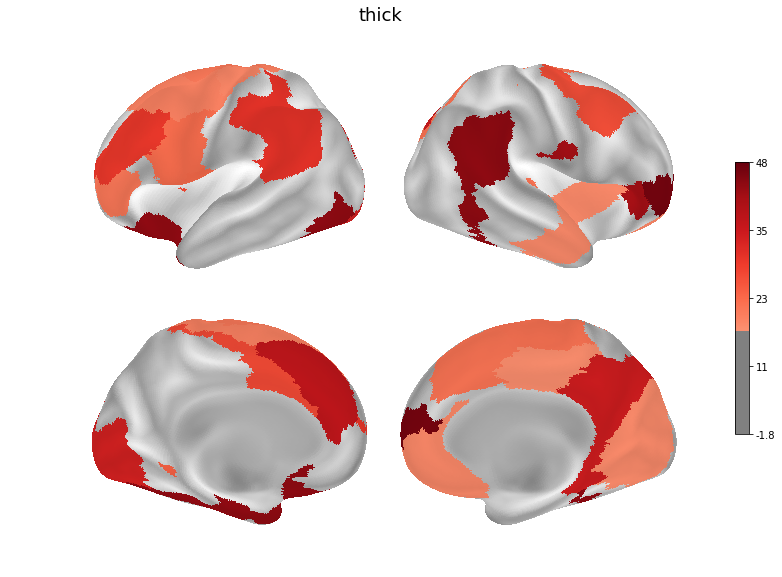

In [10]:
# Get pipelines
pipe = get_pipe('lgbm', 'random_50_0')

# Run evaluate
results = run_eval(pipe)

inverse_fis = results.get_inverse_fis()
plot_avg(inverse_fis)

## What about a voting ensemble of Elastic-Net ?

In this case, what goes on behind the scenes is that the coef_ from each of the base models are averaged. In a more detailed sense, when get inverse fis is called, the coef_ from each base ensemble are first back projected to the original space, then they are averaged. Even though each base estimator has 100 coef_, it would be wrong to average them in that space since each coef_ refers to a different parcellation, it is therefore neccisary to average only after back projection. This is taken care of internally since the nested estimators of the voting ensemble have Loader objects. Let's try it below:

Get pipeline with: elastic voted_random_100_10_1 None
Get pipeline with: elastic random_100_10 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_10_e
Get pipeline with: elastic random_100_11 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_11_e
Get pipeline with: elastic random_100_12 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_12_e
Get pipeline with: elastic random_100_13 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_13_e
Get pipeline with: elastic random_100_14 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_14_e
Get pipeline with: elastic random_100_15 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_15_e
Get pipeline with: elastic random_100_16 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_16_e
Get pipeline with: elastic random_100_17 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_17_e
Get pipeline with: elastic

Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (7538, 4) (skipped 7 NaN targets)
Validation Set: (1882, 4) (skipped 5 NaN targets)
Fit fold in 14.7 seconds.
explained_variance: 0.1055
neg_mean_squared_error: -18.81

Training Set: (7535, 4) (skipped 10 NaN targets)
Validation Set: (1885, 4) (skipped 2 NaN targets)
Fit fold in 15.7 seconds.
explained_variance: 0.0864
neg_mean_squared_error: -23.28

Training Set: (7537, 4) (skipped 9 NaN targets)
Validation Set: (1883, 4) (skipped 3 NaN targets)
Fit fold in 15.0 seconds.
explained_variance: 0.1114
neg_mean_squared_error: -21.32

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 16.2 seconds.
explained_variance: 0.1056
neg_mean_squared_error: -19.91

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 14.8 seconds.
explained_variance: 0.1107
neg_mean_squared_error: -17.27



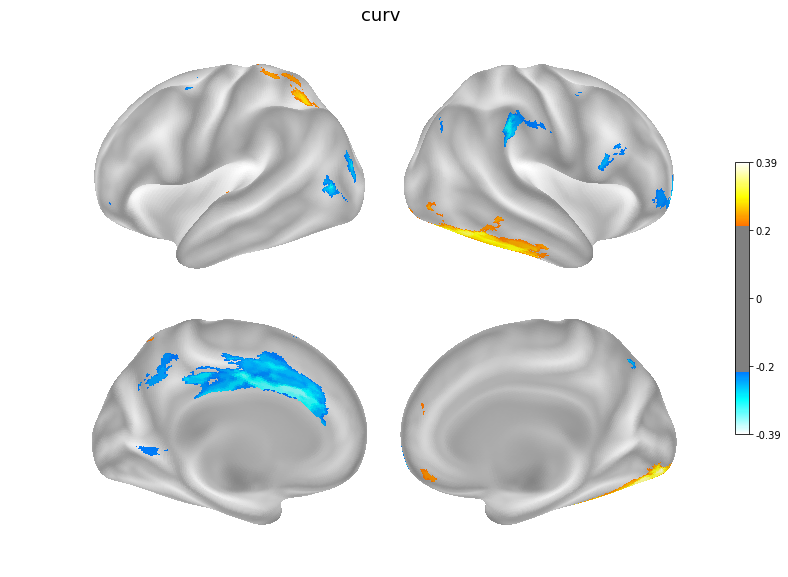

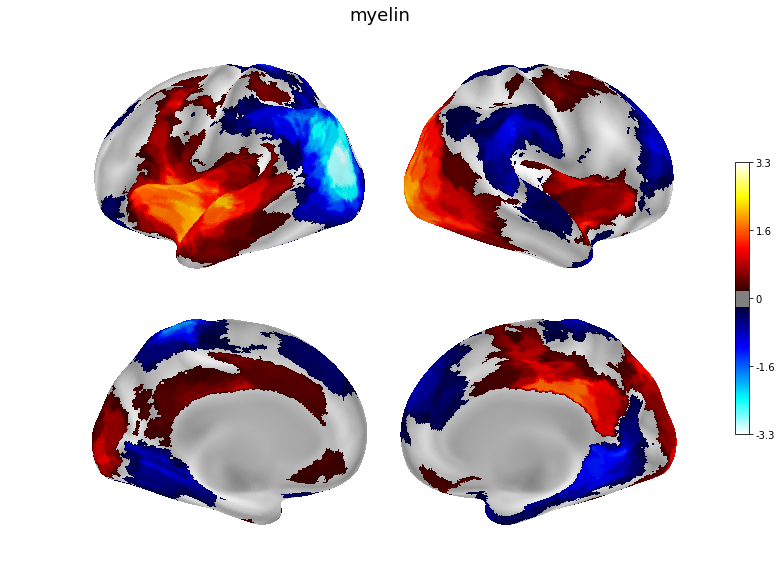

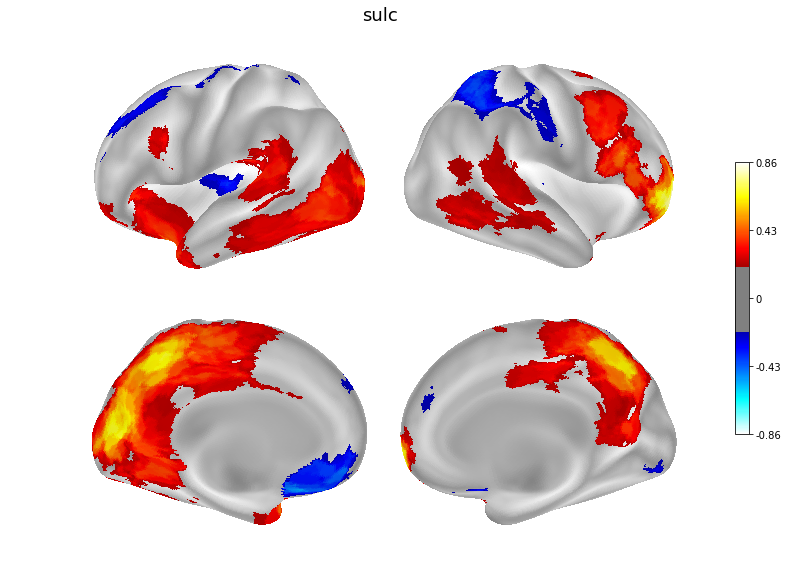

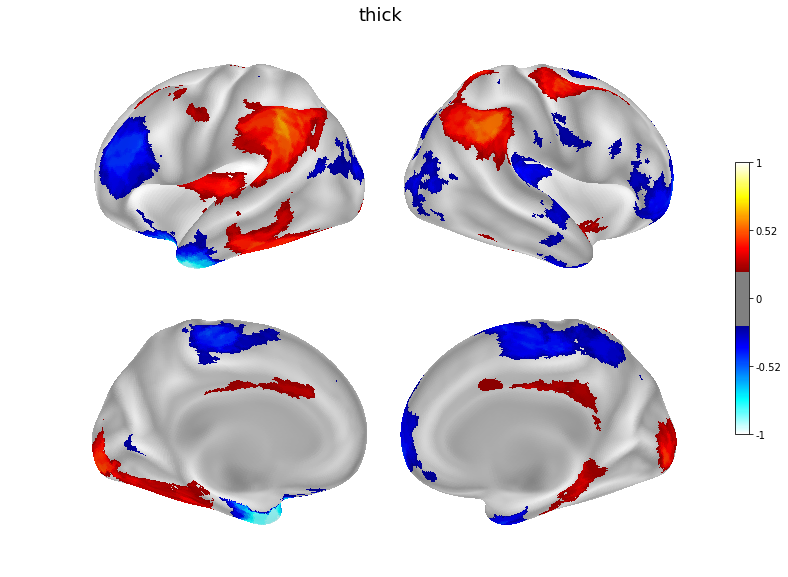

In [11]:
# Get pipeline
pipe = get_pipe('elastic', 'voted_random_100_10_1')

# Run evaluate
results = run_eval(pipe)

# Get inverse and plot
inverse_fis = results.get_inverse_fis()
plot_avg(inverse_fis)

This method is also dynamic enough to support averaging across parcellations of different sizes / with lgbm feature importances instead of coef_

Get pipeline with: lgbm voted_random_100-1000_3_0 None
Get pipeline with: lgbm random_100_0 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_100_0_e
Get pipeline with: lgbm random_550_0 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_550_0_e
Get pipeline with: lgbm random_1000_0 None
cache_fit_loc: /home/sage/parc_scaling/exp/cache_fit/random_1000_0_e
Predictions will still be made for any subjects with missing values in any validation folds.
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 4 features).
Evaluating 9432 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (7538, 4) (skipped 7 NaN targets)
Validation Set: (1882, 4) (skipped 5 NaN targets)
Fit fold in 4.2 seconds.
explained_variance: 0.1050
neg_mean_squared_error: -20.44

Training Set: (7535, 4) (skipped 10 NaN targets)
Validation Set: (1885, 4) (skipped 2 NaN targets)
Fit fold in 3.8 seconds.
explained_variance: 0.0881
neg_mean_squared_error: -23.23

Training Set: (7537, 4) (skipped 9 NaN targets)
Validation Set: (1883, 4) (skipped 3 NaN targets)
Fit fold in 6.6 seconds.
explained_variance: 0.0996
neg_mean_squared_error: -22.03

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 4.0 seconds.
explained_variance: 0.0843
neg_mean_squared_error: -21.78

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 4.5 seconds.
explained_variance: 0.1145
neg_mean_squared_error: -17.88



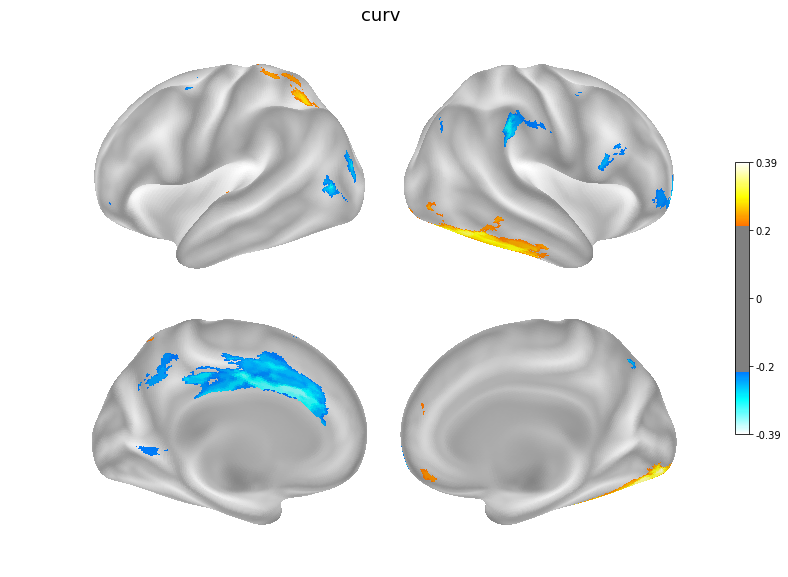

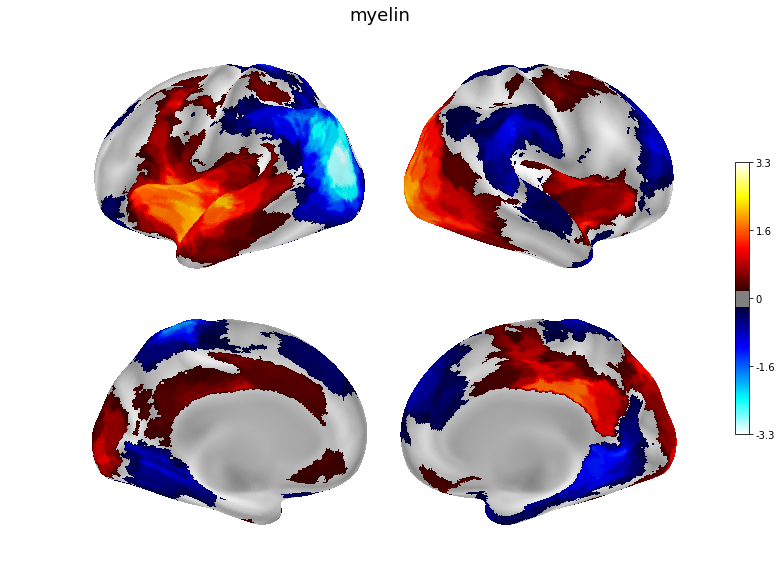

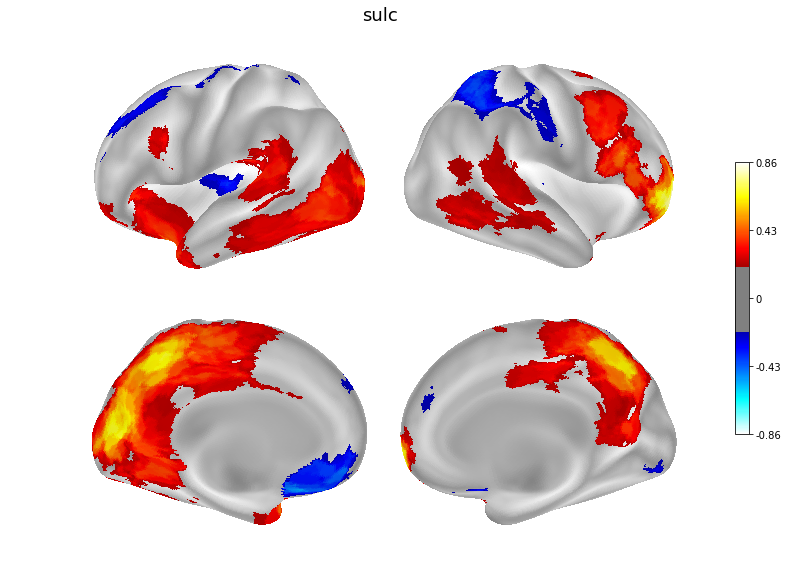

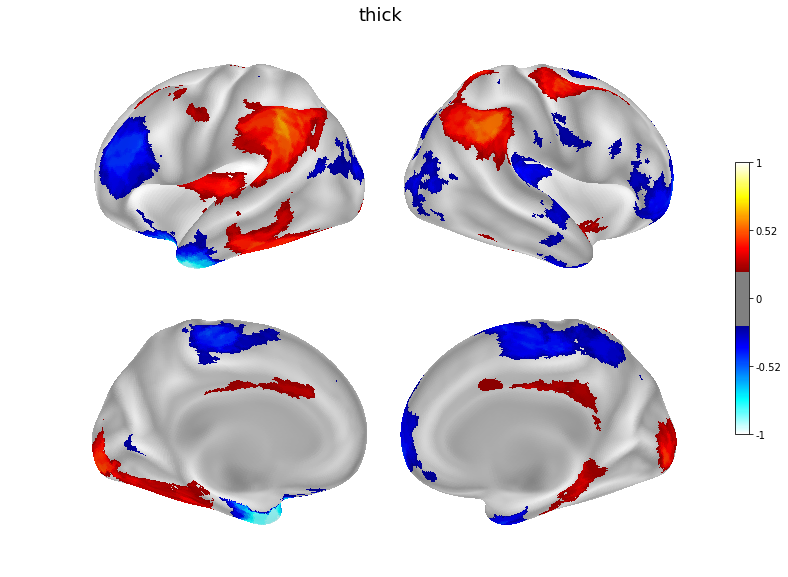

In [12]:
# Get pipeline
pipe = get_pipe('lgbm', 'voted_random_100-1000_3_0')

# Run evaluate
results = run_eval(pipe)

# Inverse and plot
results.get_inverse_fis()
plot_avg(inverse_fis)

## SVM / Permutation Feature Importance

For the Elastic-Net and LGBM, they both have default already calculated feature importances which we can back project and plot right away. For the SVM based pipelines though, this isn't possible. Instead we need to calculate feature importances in another way, in this example we will use permutation based feature importances.

In [13]:
# Get pipelines
pipe = get_pipe('svm', 'random_50_0')

# Run evaluate
results = run_eval(pipe)

Get pipeline with: svm random_50_0 None
cache_fit_loc: None
Predictions will still be made for any subjects with missing values in any validation folds.
Predicting target = anthro_waist_cm
Using problem_type = regression
Using scope = all (defining a total of 4 features).
Evaluating 9432 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (7538, 4) (skipped 7 NaN targets)
Validation Set: (1882, 4) (skipped 5 NaN targets)
Fit fold in 0.7 seconds.
explained_variance: 0.0496
neg_mean_squared_error: -20.71

Training Set: (7535, 4) (skipped 10 NaN targets)
Validation Set: (1885, 4) (skipped 2 NaN targets)
Fit fold in 0.7 seconds.
explained_variance: 0.0603
neg_mean_squared_error: -24.48

Training Set: (7537, 4) (skipped 9 NaN targets)
Validation Set: (1883, 4) (skipped 3 NaN targets)
Fit fold in 0.7 seconds.
explained_variance: 0.0559
neg_mean_squared_error: -23.45

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 0.7 seconds.
explained_variance: 0.0574
neg_mean_squared_error: -21.67

Training Set: (7535, 4) (skipped 11 NaN targets)
Validation Set: (1885, 4) (skipped 1 NaN targets)
Fit fold in 0.8 seconds.
explained_variance: 0.0755
neg_mean_squared_error: -18.67



In [ ]:
# Calculate p_fis
p_fis = results.permutation_importance(dataset=data,
                                       n_repeats=10,
                                       just_model=True,
                                       nested_model=True,
                                       return_as='dfs',
                                       n_jobs=-1)

Using scorer: explained_variance


In [ ]:
# From permutation fis can get inverse by passing alongs means
inverse_fis = results.get_inverse_fis(p_fis['importances_mean'])

# Plot
plot_avg(inverse_fis)

## SVM based voting ensemble

So the way we had the voting ensemble feature importances set up before, we took the average of each once back projected. Now what about when we have an ensemble of SVM classifiers? In this case we need to do the permutation feature importances again, but we want to ensure that the features being permuted are the fully transformed features. Let's get an example going before getting into more details...

In [ ]:
# Get pipeline
pipe = get_pipe('svm', 'voted_random_100_2_0')

# Run evaluate
results = run_eval(pipe)

So what happens internally when we are going to call `permutation_importance` is the following internal function is called to setup the proper X_val, and locate the proper sub estimator for each fold. In this case we want just just_model and nested_model to be True.

In [ ]:
# Get base X and y from dataset
X, y = data.get_Xy(results.ps)

# Call this internal methods for fold 0
estimator, X_val, y_val, feat_names =\
                results._get_val_fold_Xy(results.estimators[0],
                                         X_df=X, y_df=y,
                                         fold=0,
                                         just_model=True,
                                         nested_model=True)

Looking at X_val, we notice the shape might look a little funny - but we can confirm that it lines up with the feat names.

In [ ]:
X_val.shape, len(feat_names)

So what's going on here? First note that we have a random ensemble with two random parcellations each with size 100, and we also have 4 modalities. So that means after being loaded and transformed, each parcellation will yield  400 features, then two sub SVM models with front-end feature selection will be fed in 400 features each. So why do we have 598 features here? We can get a better idea of what these features represent if we look at the feat names

In [ ]:
feat_names[300:310], feat_names[-1]

So two things are going on here, the first you'll note is that there are some features missing. That is because these feat names and X_val represent the transformed data after any features that were selected to be removed by  the feature selection step were already removed. The other piece you'll note is the 0_ appended to the features above, and the '1_' appended to the last feature we printed. That is to say the features and X_val represent the concatenated fully transformed output from each of the two sub-svm models.

Basically, this is exactly what we want, as we need all avaliable features to be already present (i.e., not waiting to be transformed) when we pass them to the function responsible for calculating the permutation based feature importances. Essentially the last step that happens internally, that we don't need to worry about, is the 'predict' function for BPtVotingEstimator is designed to automatically detect this alternative output, we can confirm that here:

In [ ]:
estimator

In [ ]:
# The estimator despite still containing the nested Loaders
# is designed to still be able to accept the already transformed
# by its own nested Loader's input to its predict function
estimator.predict(X_val).shape

Now that we know whats going on behind the scenes, we with BPt can just do the same exact thing as before, and it will take care of the details!

In [ ]:
# Calculate p_fis
p_fis = results.permutation_importance(dataset=data,
                                       n_repeats=10,
                                       just_model=True,
                                       nested_model=True,
                                       return_as='dfs',
                                       n_jobs=-1)

# Get inverse, same as before
inverse_fis = results.get_inverse_fis(p_fis['importances_mean'])

# Plot
plot_avg(inverse_fis)

## Stacked Ensembles - Elastic-Net

Okay, now what about with a stacking based ensemble? Well, we can do something simmilar to voting, but instead of just taking the mean of the existing feature importances, we want to take a weighted average according to the feature importances of the stacking regressor itself. Though note that in order for this to work we have to make a simplification, that being that we throw away information on magnitude, and instead consider only the absolute average values according to the absolute weights of the stacker. 

In [ ]:
# Get pipeline
pipe = get_pipe('elastic', 'stacked_random_100_3_1')

# Run evaluate
results = run_eval(pipe)

# Plot inverse
results.get_inverse_fis()
plot_avg(inverse_fis)

We can also in the same manner as before consider the generation and plotting of permutation based feature importances, e.g., in the case of using an SVM based classifier instead of elastic-net

In [ ]:
# Calculate p_fis
p_fis = results.permutation_importance(dataset=data,
                                       n_repeats=10,
                                       just_model=True,
                                       nested_model=True,
                                       return_as='dfs',
                                       n_jobs=-1)

# Get inverse, same as before
inverse_fis = results.get_inverse_fis(p_fis['importances_mean'])

# Plot
plot_avg(inverse_fis)

In [ ]:
# Get pipelines - add cache fit loc before running again ... 
pipe = get_pipe('ridge', 'identity')
results = run_eval(pipe, n_jobs=1)

inverse_fis = results.get_inverse_fis()
plot_avg(inverse_fis)